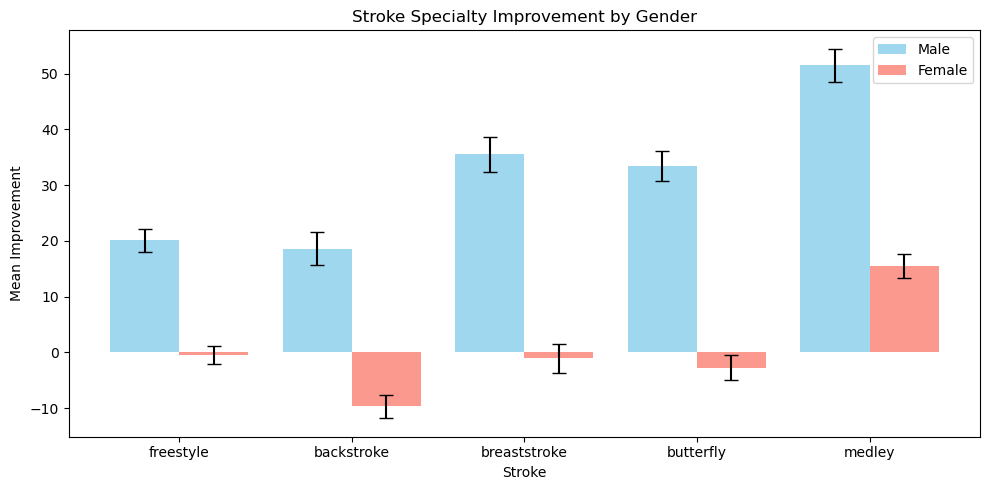

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

# Assuming your DataFrame has a 'Gender' column with values like 'M' and 'F'
df = pd.read_parquet('CLEANED_SWIM_DATA.parquet')

df.loc[:, 'isHS'] = df.loc[:, 'Division'] == 'HS'

mean_improvement_male = []
std_improvement_male = []
mean_improvement_female = []
std_improvement_female = []
n_male = []  # To store number of swimmers for each stroke and gender
n_female = []  # To store number of swimmers for each stroke and gender

stroke_categories = ['freestyle', 'backstroke', 'breaststroke', 'butterfly', 'medley']

for stroke in stroke_categories:
    for gender in ['M', 'F']:
        # Step 1: Group by swimmer ID and find their top 4 events by Points
        if stroke == 'backstroke':
            # For backstroke, exclude events that contain '50'
            top_4_per_swimmer = (
                df[(df['Gender'] == gender) & (df['Event'].str.contains(stroke, case=False)) & 
                   (~df['Event'].str.contains('50'))]
                .groupby('ID')
                .apply(lambda group: group.nlargest(4, 'Points'))
                .reset_index(drop=True)
            )
        else:
            top_4_per_swimmer = (
                df[(df['Gender'] == gender) & (df['Event'].str.contains(stroke, case=False))]
                .groupby('ID')
                .apply(lambda group: group.nlargest(4, 'Points'))
                .reset_index(drop=True)
            )
        
        # Step 2: Identify swimmers with at least 2 events in their top 4
        filtered_ids = (
            top_4_per_swimmer[top_4_per_swimmer['Event'].str.contains(stroke, case=False)]
            .groupby('ID')
            .size()
            .loc[lambda x: x >= 2]
            .index
        )
        
        # Step 3: Filter original dataset for these swimmers
        filtered_df = df[df['ID'].isin(filtered_ids) & (df['Gender'] == gender)]
        
        # Step 4: Keep only relevant stroke events
        if stroke == 'backstroke':
            # Exclude events that contain '50' in their name
            stroke_only = filtered_df[
                filtered_df['Event'].str.contains(stroke, case=False) &
                ~filtered_df['Event'].str.contains('50')
            ]
        else:
            stroke_only = filtered_df[
                filtered_df['Event'].str.contains(stroke, case=False)
            ]
        
        # Step 5: Create pivot table
        pivot_table = stroke_only.pivot_table(
            values='Points', index='ID', columns='isHS', aggfunc='mean'
        )
        
        # Compute improvement difference
        pivot_table['Difference'] = pivot_table[False] - pivot_table[True]
        pivot_table['Difference'] = pivot_table['Difference'].replace([float('inf'), -float('inf')], float('nan'))
        pivot_table = pivot_table.dropna(subset=['Difference'])
        
        mean = pivot_table['Difference'].mean()
        std = pivot_table['Difference'].std()
        
        # Compute number of swimmers (n)
        n = len(pivot_table)
        
        # Compute 95% confidence interval
        ci = 1.96 * (std / (n ** 0.5))
        
        if gender == 'M':
            mean_improvement_male.append(mean)
            std_improvement_male.append(ci)  # Using CI instead of std
            n_male.append(n)
        else:
            mean_improvement_female.append(mean)
            std_improvement_female.append(ci)  # Using CI instead of std
            n_female.append(n)

# Create DataFrame for visualization
data = {
    'Stroke': stroke_categories,
    'Mean Improvement (M)': mean_improvement_male,
    'CI (M)': std_improvement_male,  # Using CI instead of standard deviation
    'Mean Improvement (F)': mean_improvement_female,
    'CI (F)': std_improvement_female  # Using CI instead of standard deviation
}

df_vis = pd.DataFrame(data)

# Plot the grouped bar chart
fig, ax = plt.subplots(figsize=(10, 5))
x = range(len(stroke_categories))

bar_width = 0.4  # Width of the bars

ax.bar([i - bar_width/2 for i in x], df_vis['Mean Improvement (M)'], yerr=df_vis['CI (M)'], 
       capsize=5, color='skyblue', alpha=0.8, width=bar_width, label='Male')

ax.bar([i + bar_width/2 for i in x], df_vis['Mean Improvement (F)'], yerr=df_vis['CI (F)'], 
       capsize=5, color='salmon', alpha=0.8, width=bar_width, label='Female')

# Labels and title
ax.set_xticks(x)
ax.set_xticklabels(stroke_categories)
ax.set_xlabel('Stroke')
ax.set_ylabel('Mean Improvement')
ax.set_title('Stroke Specialty Improvement by Gender')
ax.legend()

plt.tight_layout()
plt.show()
